In [1]:
# Import Dependencies

from time import sleep
# from features import get_features
from mido import MidiFile
import pandas as pd

from datetime import date
from time import time, monotonic
from os import path, mkdir, listdir, environ
import subprocess


In [2]:
# Get Args, define evaluation groups

iterations = 1        # How many times each experiment should be repeated for the same parameters?
max_input_bars = 4    # What is the maximum lookback size for each model?
max_output_bars = 4   # What is the maximum output size for each model?
# sample_length = 32    # How long of a final composition should be generated?
sample_length = 8     # How long of a final composition should be generated?

client  = None        # Client Process
server  = None        # Server Process
expname = ''          # Experiment Name, for naming files

ip = "127.0.0.1"
port = 5005
port_in = 57120

modelname = None
checkpointname = None

evaluation_sets = [
  # ('bach-chorales', [
  ('bach10', [
    # ('polyphony_rnn', 'polyphony_rnn'),
    # ('pianoroll_rnn_nade', 'rnn-nade_attn'),
    ('rl_duet', 'rl_duet'),
  ]),
  ('piano-e-comp', [
    # ('performance_rnn', 'performance_with_dynamics'),
    # ('music_transformer', 'performance_with_dynamics')
  ]),
  (None, [
    # ('melody_rnn', 'attention_rnn')
  ]),
  (None, [
    # ('remi', 'remi')
  ])
]


cols_gen = [ "model", "checkpoint", "dataset", "primer", "iteration", "out_file", "time", "in_len", "out_len" ]

In [3]:
# Folder Definitions
primerdir = ''
# outputdir = path.join(path.pardir,'output')
# datasetdir = path.join(path.pardir,'dataset') 
outputdir = path.join(path.curdir,'output')
datasetdir = path.join(path.curdir,'dataset')
basefoldername = str(date.today())
i = 0
while True:
    foldername = f'{basefoldername}-{i}'
    full_foldername = path.join(outputdir, foldername)

    if not path.exists(full_foldername):
      mkdir(full_foldername)
      break

    if not any(listdir(full_foldername)): break
    i = i + 1


# File Management
def get_filename(expname,index,primer=None):
  return path.normpath(
    f"{foldername}/{expname}-{index}"
    if primer is None else
    f"{foldername}/{expname}-{primer}-{index}")

def get_primer_filename(name):
  return path.join(primerdir,name)

def get_midi_filename(expname,index,primer=None):
  return path.join(outputdir, f'{get_filename(expname,index,primer)}.mid')

def get_pickle_filename(expname,index,primer=None):
  return path.join(outputdir, f'{get_filename(expname,index,primer)}.pkl')

def save_df(df, filename):
    # log(f'Saving dataframe to {filename}')
    df.to_pickle(filename)

def log(message):
    print(f'[batch:{expname}] {message}')

In [4]:
# Define Experiments

from functools import reduce

def generate_sample(primer, bars_input, bars_output, index):
  client.reset()
  client.load_bars(get_primer_filename(primer), bars_input)

  i = 0
  start_time = monotonic()
  while bars_input + i * bars_output < sample_length:
    client.generate(bars_output, 'measures')
    i += 1
  gentime = monotonic() - start_time

  filename = get_filename('generation',index,f'{start_time}-{bars_input}-{bars_output}-{primer}')
  client.save(filename)
  return filename, gentime

def run_iteration(model, checkpoint, dataset, primer, i):
  return [[model, checkpoint, dataset, primer, i, *generate_sample(primer, bars_input, bars_output, i), bars_input, bars_output]
    for bars_input
    in range(1,max_input_bars + 1)
    for bars_output
    in range(1,max_output_bars + 1)
  ]

def run_generation(model,checkpoint,dataset):
  p = [run_iteration(model,checkpoint,dataset,primer, i) for primer in primers for i in range(iterations)]
  out = []
  for pp in p:
    out.extend(pp)
  return out

In [5]:
# Start Client, define model management functions
from pythonosc import udp_client, osc_server
from pythonosc.dispatcher import Dispatcher

class BatchClient(udp_client.SimpleUDPClient):
  def __init__(self, logger, ip, port_out, port_in):
    udp_client.SimpleUDPClient.__init__(self, ip, port_out, port_in)
    dispatcher = Dispatcher()
    dispatcher.map('/ok', lambda _: self.server.shutdown())
    self.server = osc_server.ThreadingOSCUDPServer((ip, port_in), dispatcher)
    self.log = logger

  def request(self, endpoint, args):
    self.log(f'{endpoint} {" ".join([str(a) for a in args])}')
    self.send_message(endpoint, args)

  def start(self):
    self.request('/start', [])

  def stop(self):
    self.request('/stop', [])

  def set(self,*args):
    self.request('/set', args)

  def debug(self,key):
    self.request('/debug', [key])

  def save(self,filename):
    self.request('/save', [filename])
    self.wait()

  def play(self,note):
    self.request('/play', [note + 40])

  def run(self,filename):
    self.set('output_filename', filename)
    self.start() # TODO: on host: unset 'batch_complete'
    self.wait()

  def reset(self):
    self.request('/reset', [])
  
  def pause(self):
    self.request('/pause', [])

  def end(self):
    self.request('/end', [])

  def generate(self, length, unit):
    self.request('/generate', [length, unit])
    self.wait()

  def wait(self):
    self.log("waiting...")
    self.server.serve_forever()
    self.log("ok!")
  
  def load_bars(self,filename,barcount):
    self.request('/load_bars', [filename, barcount])
    self.wait()

client = BatchClient(log, ip,  port,  port_in)
logfile = None
def start_model(the_modelname, the_checkpointname):
    logfile = open(path.join(outputdir, f'{the_modelname}.log'), 'w')
    modelname = the_modelname
    checkpointname = the_checkpointname
    log(f'Starting model: {modelname} ({checkpointname})')
    env = environ.copy()
    env['NOT_INTERACTIVE'] = '1'
    # server = subprocess.Popen([ './start.sh', model, checkpoint, 'batch' ], cwd=path.pardir, env=env)
    server = subprocess.Popen([ './start.sh', modelname, checkpointname, 'batch' ], env=env, stdout=logfile, stderr=logfile)
    # server.communicate()
    client.wait()
    client.set('debug_output', False)
    client.set('batch_mode', True)
    client.set('trigger_generate', 1)
    client.set('batch_unit', 'measures')
    client.set('debug_output', False)

def stop_model():
  if client: client.end()
  if server: server.wait()
  if logfile: logfile.close()


In [6]:
# Generation Phase

import pickle

max_primers = None
max_primers = 5

try:
    log(f'Starting experiment suite: {outputdir}/{foldername}')
    output = []
    for dataset, models in evaluation_sets:
        if dataset is None: continue
        datapath = path.join(datasetdir, dataset)
        primerdir = datapath
        if not path.exists(datapath):
            print(f'Directory not found: {datapath}, skipping')
            continue

        primers = listdir(datapath)
        if max_primers: primers = primers[:max_primers]

        for (model, checkpoint) in models:
            expname = model
            start_model(model, checkpoint)

            e = run_generation(model,checkpoint,dataset)

            output += e
            stop_model()
    print(output)
    # Save temp file
    with open('output.tmp', 'wb') as f:
      pickle.dump(output, f)
    
    # Create DataFrame
    df = pd.DataFrame(output, columns=cols_gen)
    print(df.describe())
    save_df(df,path.join(outputdir, 'df_gen'))
    

except KeyboardInterrupt:
  print("Terminating...")
  client.pause()
finally:
  stop_model()

print("Done!")

duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /reset 
[batch:rl_duet] /load_bars ./dataset/bach10/05-DieNacht.mid 1
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /generate 3 measures
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /generate 3 measures
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /generate 3 measures
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /save 2021-05-26-0/generation-107681.574826499-1-3-05-DieNacht.mid-0
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /reset 
[batch:rl_duet] /load_bars ./dataset/bach10/05-DieNacht.mid 1
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /generate 4 measures
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /generate 4 measures
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_duet] /save 2021-05-26-0/generation-107689.282916125-1-4-05-DieNacht.mid-0
[batch:rl_duet] waiting...
[batch:rl_duet] ok!
[batch:rl_due

In [7]:
# Analysis Stage

import os
import subprocess
import glob
import json
import pandas as pd
outputdir = os.path.abspath(os.path.join(os.curdir, 'output'))
df_gen = pd.read_pickle(os.path.join(outputdir, 'df_gen'))
metricsfile = os.path.join(outputdir, 'metrics')

output_samples_dir  = os.path.join(outputdir, 'samples')
output_dataset_dir  = os.path.join(outputdir, 'dataset')

# Define External Commands
extraction_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'mgeval'))
extraction_script = os.path.join(extraction_scriptdir, 'start.sh') 
cmd_extraction = [ 'bash', extraction_script, output_samples_dir, output_dataset_dir, metricsfile, str(sample_length) ]

preprocess_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'miditools'))
preprocess_script = os.path.join(preprocess_scriptdir, 'midisox_py')
cmd_preprocess = lambda _in, _out: [ 'python', preprocess_script, '-m', os.path.abspath(_in), os.path.abspath(_out) ]

# Prepare output log file
logfile = open(path.join(outputdir, f'analysis.log'), 'w')

# Prepare Metrics DF
df_metrics = df_gen

# Prepare Output Data Fields
# for metric in metrics:
    # df_metrics[metric] = None
metriccolumns = ['model', 'in_len', 'out_len', 'iteration']
metrics_initialized = False
out = []


datadirs = [ output_samples_dir, output_dataset_dir ]

# Iterate combinations of input/output windows
grouping = df_metrics.groupby(['model', 'in_len', 'out_len', 'dataset', 'iteration'])
for (model, inn, outn, dataset, iteration), outfiles in grouping.out_file:
    expname = model

    for _dir in datadirs:
        # Check that directory exists
        if not os.path.exists(_dir):
            os.mkdir(_dir)

        # Clean output directory
        for file in glob.glob(os.path.join(_dir,'*')):
            # log(f'removing: {file}')
            if not os.path.exists(file): continue
            if os.path.islink(file): os.unlink(file)
            else: os.remove(file)

    # Remove previous metrics file if any (for sanity)
    if os.path.exists(metricsfile):
        os.remove(metricsfile)

    # Prepare Baseline Dataset Samples
    dataset_samples = glob.glob(os.path.join(os.path.curdir, 'dataset', dataset, '*'))
    
    # FIXME
    dataset_samples = dataset_samples[:len(outfiles.unique())]
    for index, filename in enumerate(dataset_samples):
        out_filename = os.path.join(outputdir, 'dataset', f'sample-{index}.mid')
        subprocess.call(cmd_preprocess(filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)
    
    # Prepare Output Samples 
    for o, outfile in enumerate(outfiles.unique()):

        # Create link to file
        in_filename = os.path.abspath(os.path.join("output", f"{outfile}.mid"))
        out_filename = os.path.abspath(os.path.join(output_samples_dir, f'sample-{o}.mid'))
        # log(f'creating: {file}')
        # log('processing: ' + ' '.join(cmd_preprocess(in_filename, out_filename)))
        # log(f'({inn} | {outn} bars) processing file: {in_filename} -> {out_filename}')
        subprocess.call(cmd_preprocess(in_filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)

    # Extract Features
    subprocess.call(cmd_extraction, stdout=logfile, stderr=logfile, cwd=extraction_scriptdir)

    # Read Extracted features
    with open(metricsfile, 'r') as metricsfile_:
        row_metrics = json.load(metricsfile_)

    # Initialize Metrics (if necessary)
    if not metrics_initialized:
        metrics_initialized = True
        for metric in row_metrics.keys():
            metriccolumns.extend([metric + '_kl_div', metric + '_overlap'])
    

    row = [model, inn, outn, iteration]
    # print(row_metrics)
    for metric in row_metrics.keys():
        [_mean, _std, _kl_div, _overlap, _training_set_kl_div, _training_set_overlap] = row_metrics[metric]
        row.extend([ _kl_div, _overlap ])
    out.append(row.copy())

logfile.close()

# Save values to output DF
print(pd.DataFrame(out, columns=metriccolumns))
df = df_metrics.merge(pd.DataFrame(out, columns=metriccolumns), how='inner', on=['model', 'in_len', 'out_len', 'iteration'])

df_metrics.to_pickle(path.join(outputdir, 'df_metrics'))

      model  in_len  out_len  iteration  bar_pitch_class_histogram_kl_div  \
0   rl_duet       1        1          0                          0.378001   
1   rl_duet       1        2          0                          0.378001   
2   rl_duet       1        3          0                          0.378001   
3   rl_duet       1        4          0                          0.378001   
4   rl_duet       2        1          0                          0.022906   
5   rl_duet       2        2          0                          0.022906   
6   rl_duet       2        3          0                          0.022906   
7   rl_duet       2        4          0                          0.022906   
8   rl_duet       3        1          0                          0.060180   
9   rl_duet       3        2          0                          0.060180   
10  rl_duet       3        3          0                          0.060180   
11  rl_duet       3        4          0                          0.060180   

            time_avg
model        rl_duet
checkpoint   rl_duet
in_len              
1           7.143943
2           7.469081
3           5.807833
4           4.425782
            time_avg
model        rl_duet
checkpoint   rl_duet
in_len              
1           8.839051
2           7.016833
3           6.697090
4           6.644739
             time_avg
model         rl_duet
checkpoint    rl_duet
in_len               
1            8.656966
2           11.290422
3            7.839206
4            6.203021
             time_avg
model         rl_duet
checkpoint    rl_duet
in_len               
1            8.195577
2           12.041232
3           14.143860
4            4.656554
            time_avg
model        rl_duet
checkpoint   rl_duet
out_len             
1           7.143943
2           8.839051
3           8.656966
4           8.195577
             time_avg
model         rl_duet
checkpoint    rl_duet
out_len              
1            7.469081
2            7.016833
3           

<Figure size 432x288 with 0 Axes>

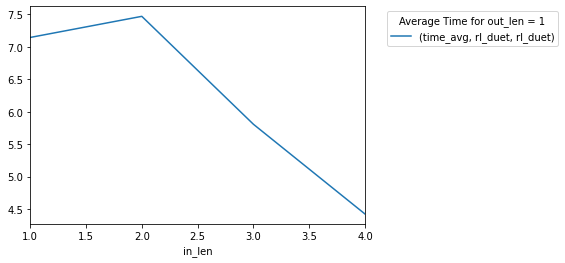

<Figure size 432x288 with 0 Axes>

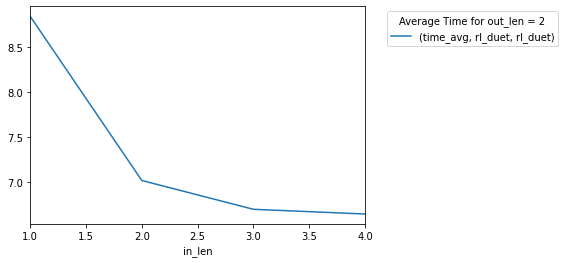

<Figure size 432x288 with 0 Axes>

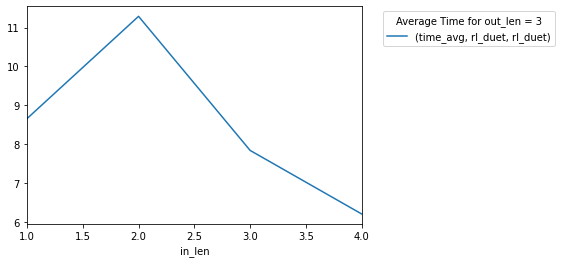

<Figure size 432x288 with 0 Axes>

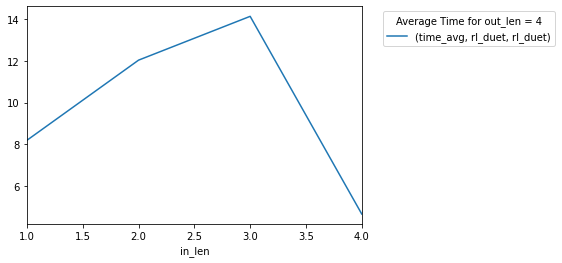

<Figure size 432x288 with 0 Axes>

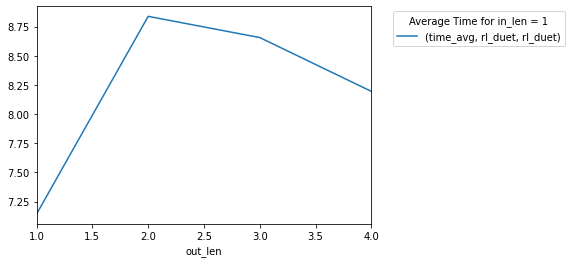

<Figure size 432x288 with 0 Axes>

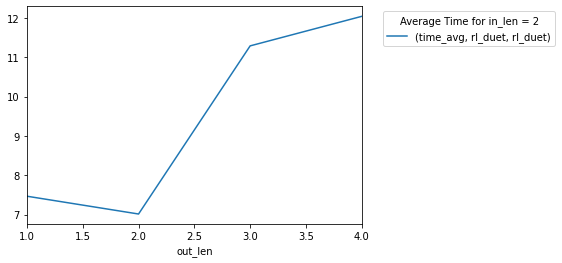

<Figure size 432x288 with 0 Axes>

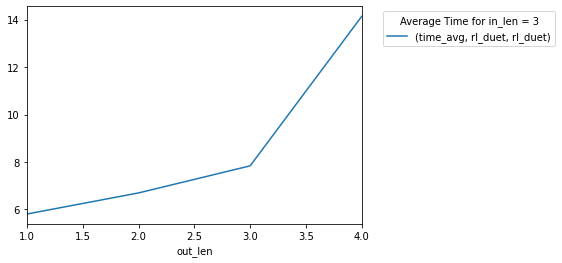

<Figure size 432x288 with 0 Axes>

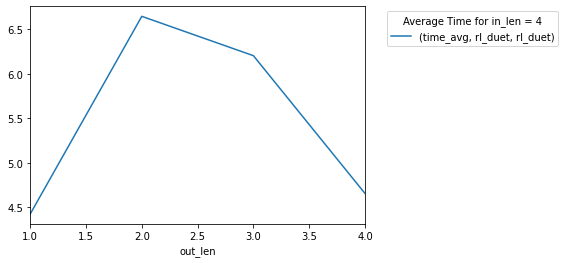

In [9]:
# Plotting phase

import matplotlib.pyplot as plt
import seaborn as sns

suffix = '_avg'
make_heat_maps = False
make_kldiv_plots = False
make_overlap_plots = False
make_time_plots = True

# Read DF
df = pd.read_pickle(path.join(outputdir, 'df_metrics'))

# Calculate Mean Values for each in/out len combination
df = df.drop(['out_file', 'primer', 'iteration'], axis=1)
df = df.groupby(['model', 'checkpoint', 'dataset', 'in_len', 'out_len']).mean()
df = df.add_suffix(suffix).reset_index()

# Get in/out len dimensions
max_in = max(df['in_len'])
max_out = max(df['out_len'])

# Get Evaluation Metric Names
eval_metrics = ['time' + suffix] + [c for c in list(df.columns) if c.endswith('overlap' + suffix) or c.endswith('kl_div' + suffix)]

overlaps = [m for m in eval_metrics if m.endswith('overlap' + suffix)]
kl_divs  = [m for m in eval_metrics if m.endswith('kl_div' + suffix)]

# Iterate Models
grouping = df.groupby(['model', 'checkpoint', 'dataset'])
for (model, checkpoint, dataset), inner_df in grouping:
    # inner_df = inner_df.groupby(['in_len', 'out_len'])
    if not make_heat_maps: continue
    for metric in eval_metrics:
        mdf = inner_df[['in_len', 'out_len', metric]]
        mdf = pd.pivot_table(mdf, values=metric, index=['in_len'], columns=['out_len'], fill_value=0)
        plt.figure()
        plt.title(f'{metric} - {model} {checkpoint} {dataset}')
        # print(sns.heatmap(mdf, cmap='RdYlGn_r', linewidths=0.5, annot=True))
        sns.heatmap(mdf, cmap='RdYlGn_r', linewidths=0.5, annot=True)
        #plt.pcolor(mdf)
        #plt.title(metric)
        
        # plt.savefig()



# make_line_plots

plot_sets =[
    ('Average Overlaps with Base Dataset', overlaps),
    ('Average KL-Divergence against Base Dataset', kl_divs),
    # ('Average Generation Time', ['time_avg'])
]

# TODO: Line Plots
# How does Input Length affect each metric for a model
for (model, checkpoint, dataset), inner_df in grouping:
    in_len_plot = inner_df.loc[inner_df['out_len'] == 1]
    x = 'in_len'
    if not make_kldiv_plots: continue
    for title, cols in plot_sets:
        plt.figure()
        in_len_plot[[x] + cols].plot(x=x, colormap='jet', markersize=10)
        plt.title(model)
        plt.legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')

for (model, checkpoint, dataset), inner_df in grouping:
    out_len_plot = inner_df.loc[inner_df['in_len'] == 1]
    x = 'out_len'
    if not make_overlap_plots: continue    
    for title, cols in plot_sets:
        plt.figure()
        out_len_plot[[x] + cols].plot(x=x, colormap='jet', markersize=10)
        plt.title(model)
        plt.legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    
# model, checkpoint

plots = ['in_len', 'out_len']
for l in plots:
    cols = ['time_avg']
    if not make_time_plots: continue
    counterpart = [i for i in plots if i != l][0]
    for i in df[counterpart].unique():
        time_plot = df.loc[df[counterpart] == i]
        time_plot = time_plot[['model', 'checkpoint', l] + cols]
        time_plot = pd.pivot_table(time_plot, values=cols, index=[l], columns=['model', 'checkpoint'], fill_value=0)
        print(time_plot)
        plt.figure()
        time_plot.plot()
        plt.legend(title=f'Average Time for {counterpart} = {i}', bbox_to_anchor=(1.05, 1), loc='upper left')
